In [2]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

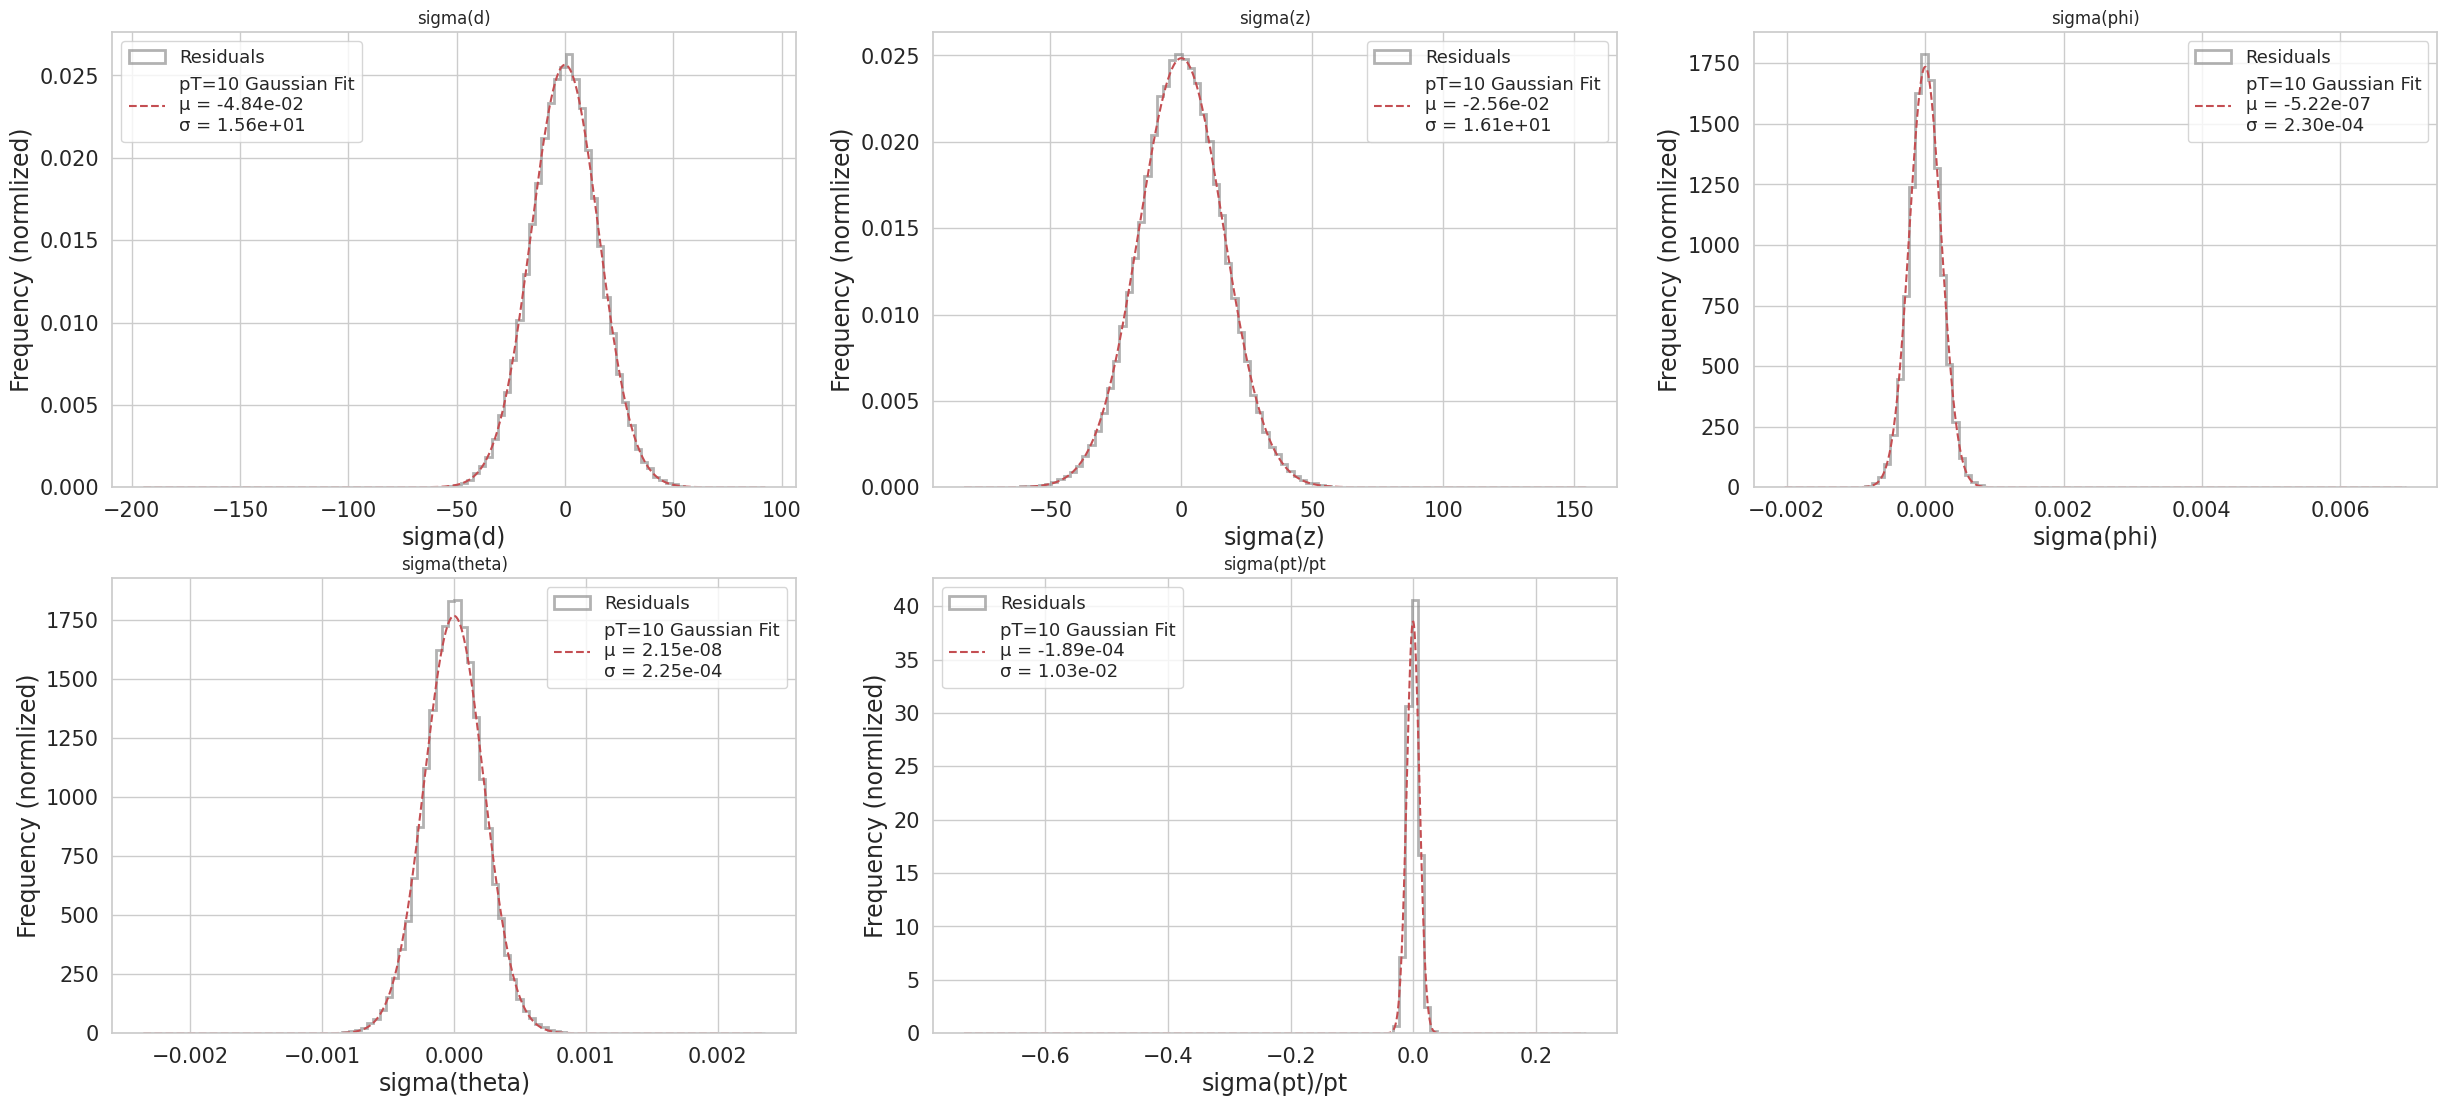

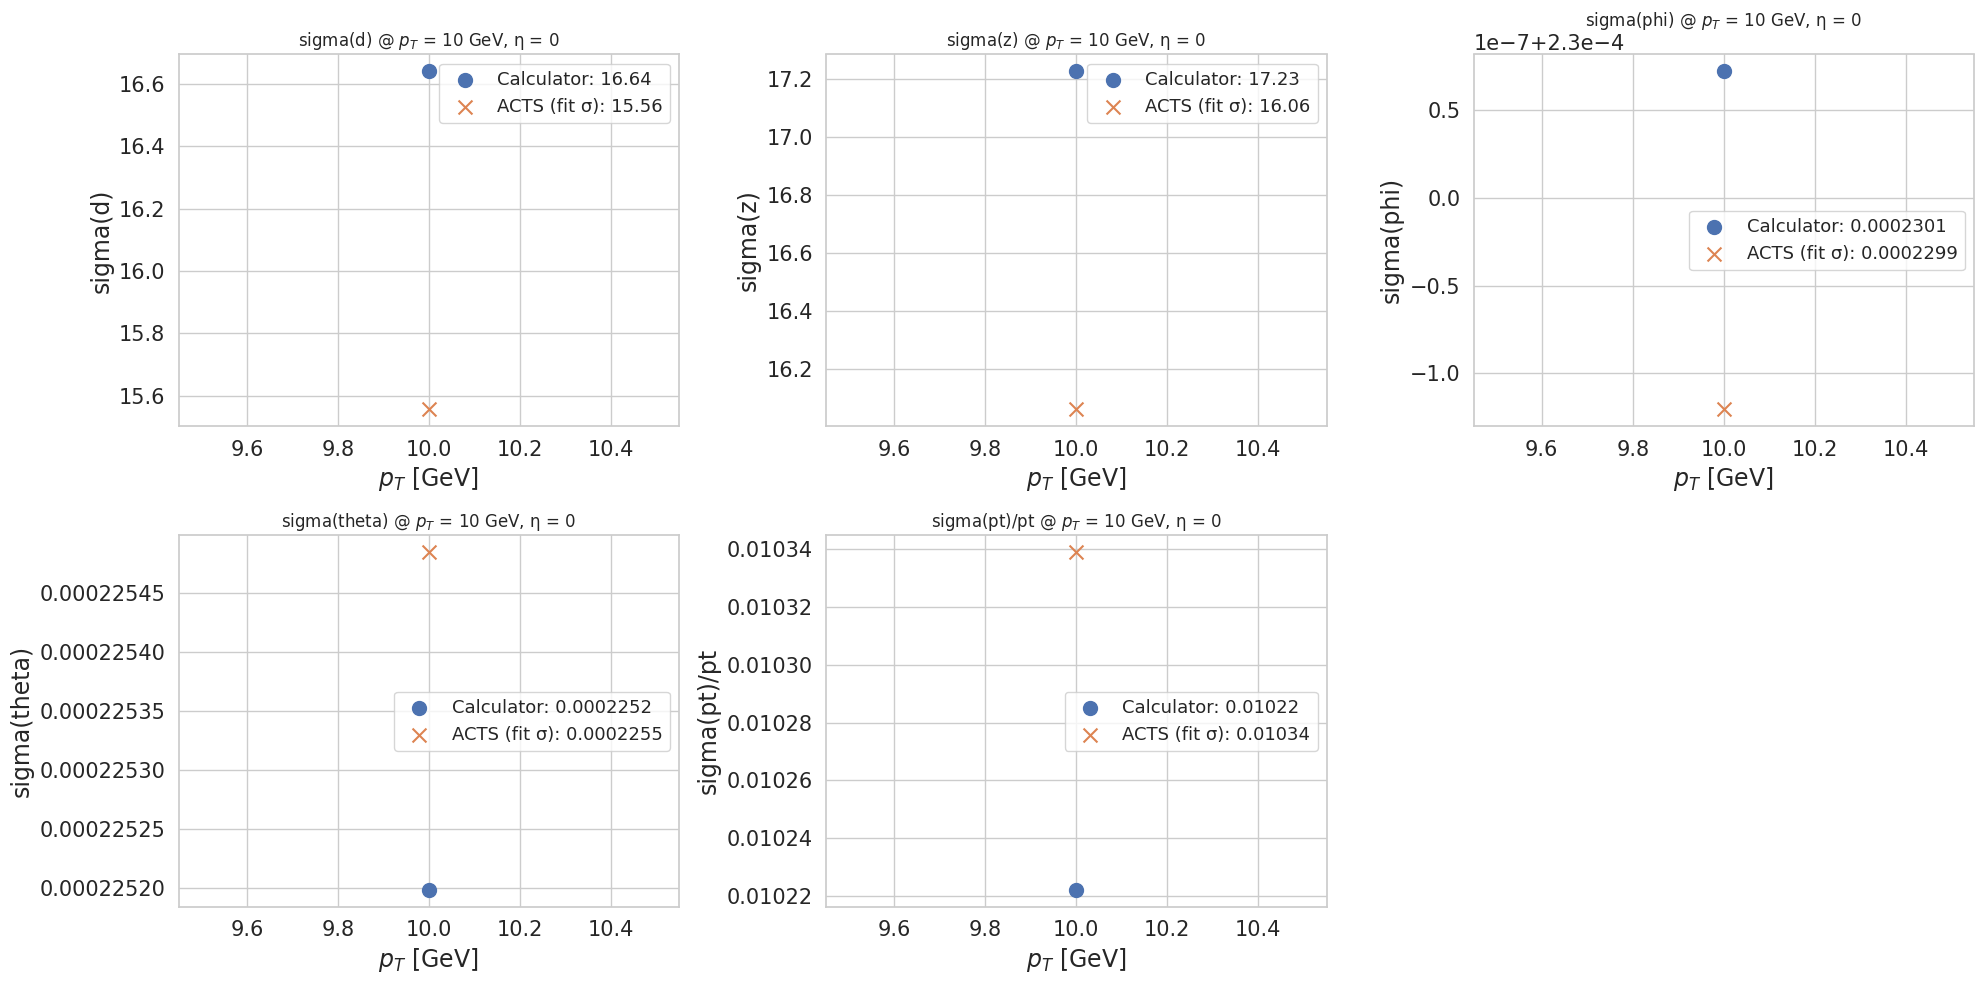

In [4]:
path = '/data/jlai/iris-hep/res_pT2/'
pT_values = np.arange(10, 100, 10)
i = 0
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_eQOP_fit", "pull_eQOP_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth) / pT_truth)
}

fit_results = {}
plt.figure(figsize=(30, 13))
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(key)
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

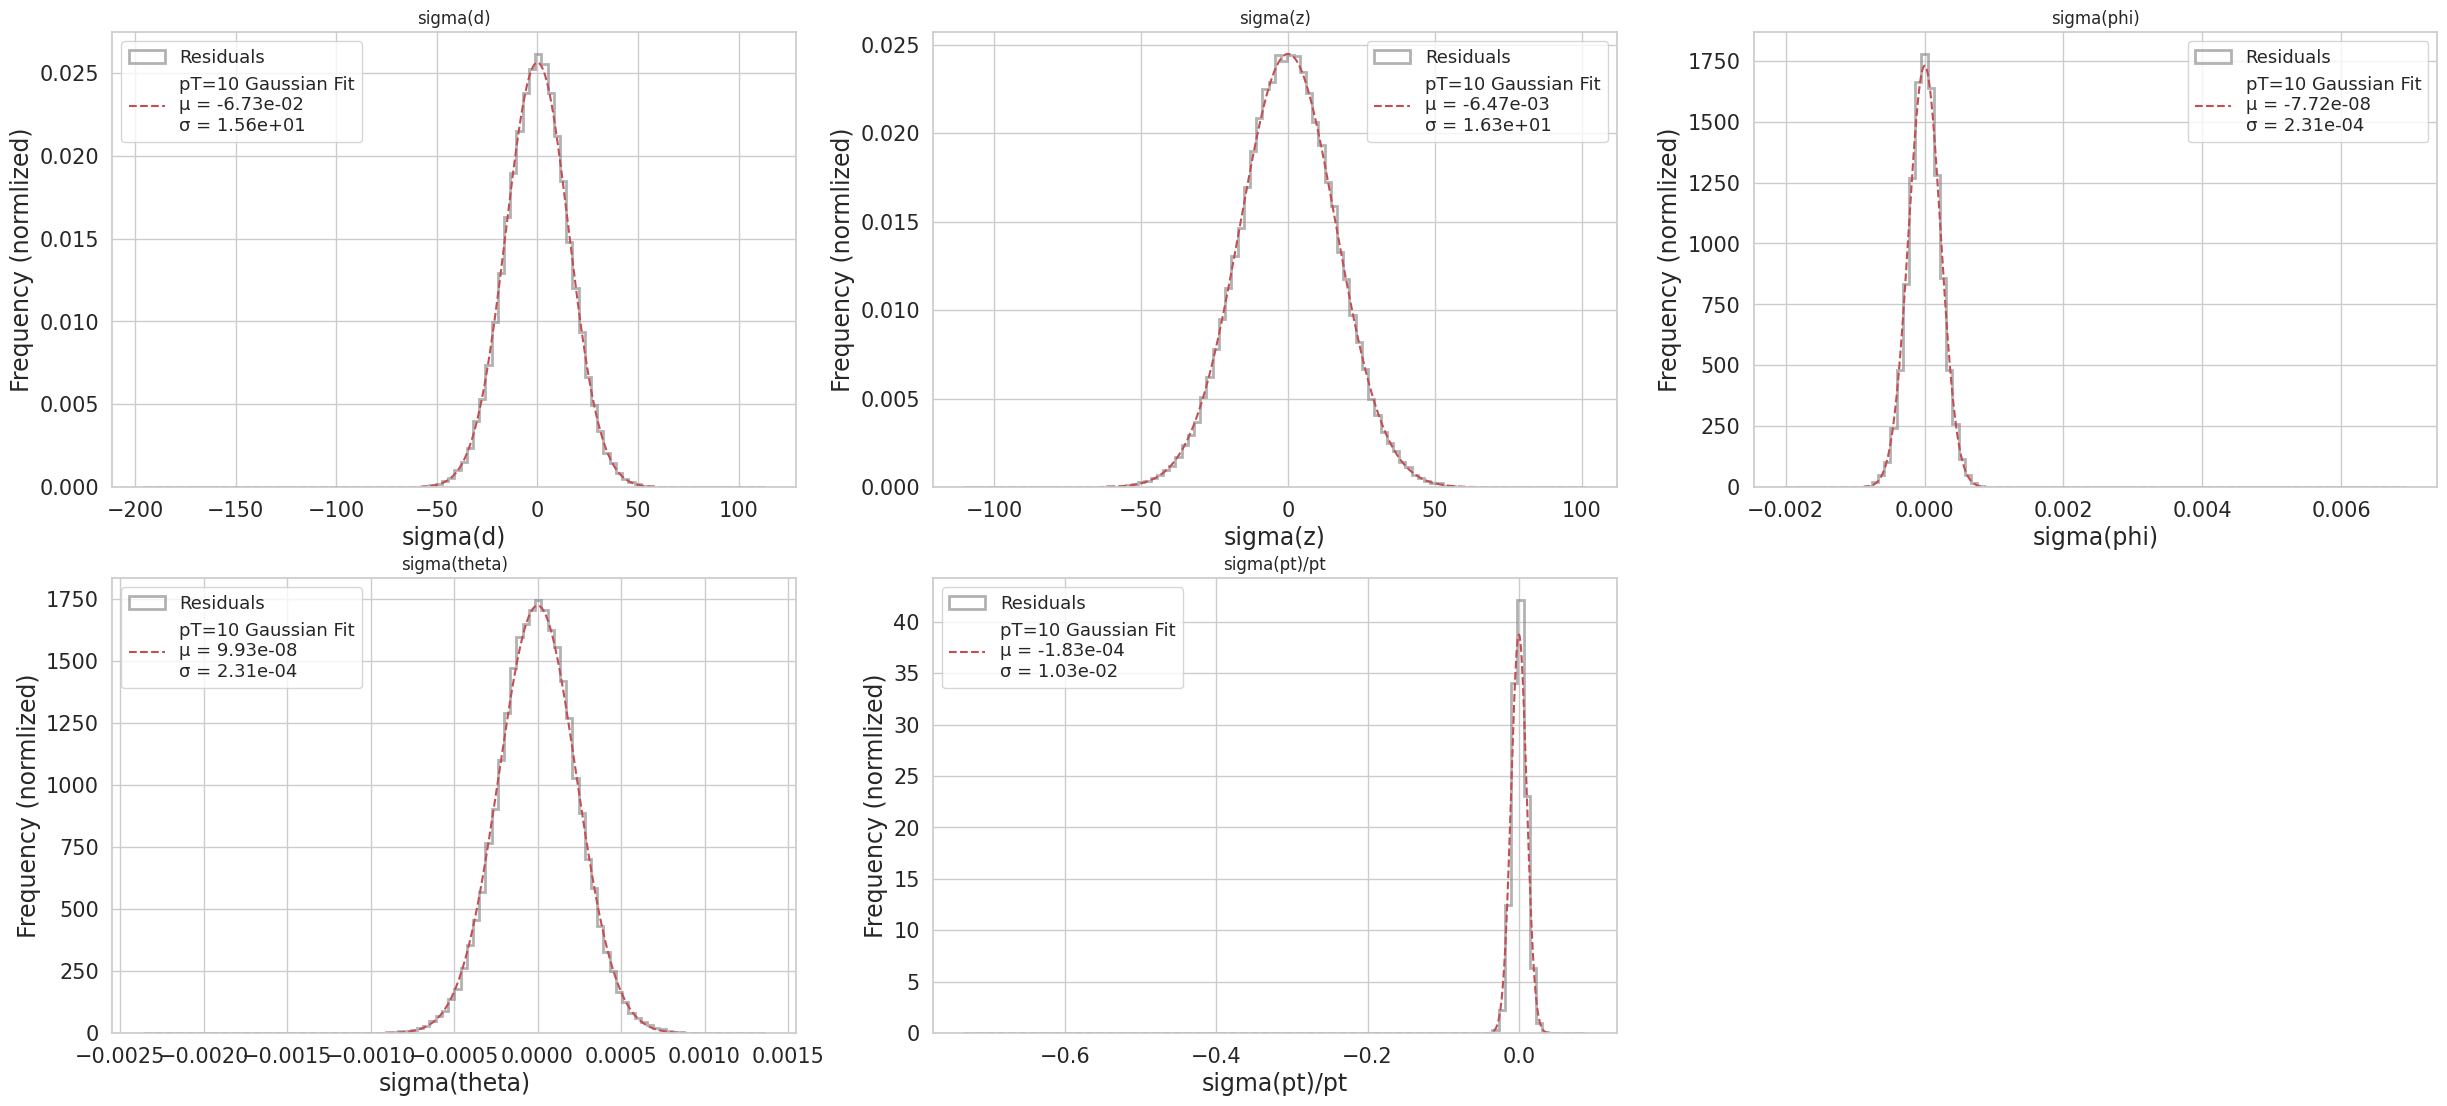

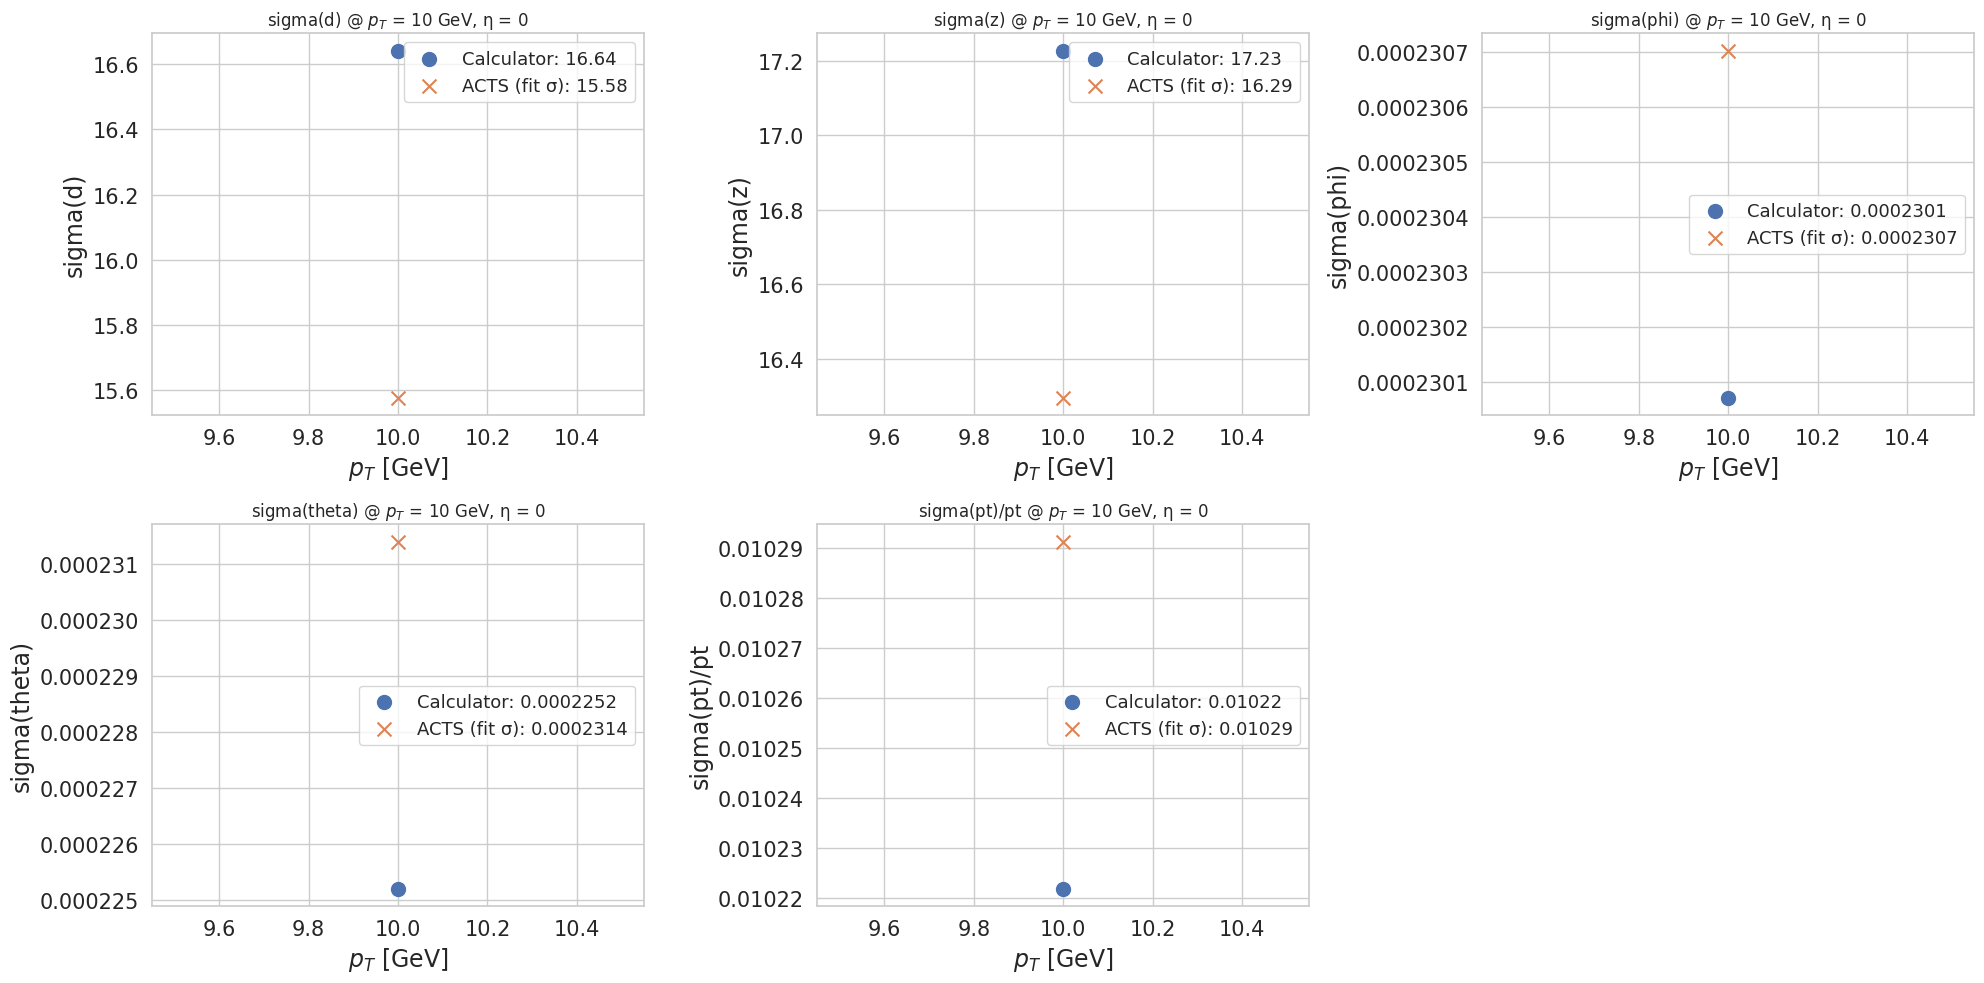

In [5]:
path = '/data/jlai/iris-hep/OutputPT/'
# pT_values = [1, 3, 5, 10]
pT_values = np.arange(10, 100, 10)
i = 0
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_eQOP_fit", "pull_eQOP_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth) / pT_truth)
}

fit_results = {}
plt.figure(figsize=(30, 13))
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(key)
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()